In [11]:

%reset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

'''
Hyper-parameters Settings
'''
HAMPEL_WINDOW_SIZE = 21
HAMPEL_THRESHOLD = 1
HAMPEL_IMPUTATION = True

'''
Path Settings
'''
CONFIGURATION_FILE_PATH = "./data/train/data_config.csv"
DATASET_PATH = "./data/train/"

'''
Program Configurations
'''
COP_OUTPUT_SAVE_IMAGE = False
COP_OUTPUT_SAVE_CSV = True
LOADCELL_OUTPUT_SAVE_IMAGE = False
LOADCELL_OUTPUT_SAVE_CSV = True
FSR_SCALEUP_OUTPUT_SAVE_IMAGE = True
FSR_SCALEUP_COMPARE_SAVE_IMAGE = True
FSR_REGION_CROP_ENABLE = True
DYNAMIC_FSR_SCALEUP = True


'''
Figure Settings
'''
pd.set_option('display.width', 200) # for display width

print("done.")

Nothing done.
done.


In [12]:

'''
1. Read Configurration File (only xls)
'''
data_config = pd.read_csv(CONFIGURATION_FILE_PATH, header=0, index_col=0)
print("Configuration Dataframe dimension: ", data_config.shape)


Configuration Dataframe dimension:  (49, 12)


In [13]:
'''
2. Read all FSR matrix data and Seat sensor data
'''
fsr_dataframe = {}
seat_dataframe = {}

for idx in data_config.index:
    fsr_filepath = DATASET_PATH+data_config.loc[idx, "fsr_matrix_1d_datafile"] # set FSR matrix data filepath
    seat_filepath = DATASET_PATH+data_config.loc[idx, "seat_datafile"] # set Seat data filepath
    print(idx, ") read data files : ", fsr_filepath, ",", seat_filepath)

    fsr_dataframe[idx] = pd.read_csv(fsr_filepath, header=0, index_col=False).iloc[:,0:162] # read FSR matrix data file
    seat_dataframe[idx] = pd.read_csv(seat_filepath, header=0, index_col=False) # read Seat data file

    # clear unnecessary columns
    del seat_dataframe[idx]['Measurement time'] # remove unnecessary column
    del fsr_dataframe[idx]['Measurement Time (sec)'] # remove unnecessary column
print("done.")

1 ) read data files :  ./data/train/20210303T160024-1dm.csv , ./data/train/data_01m.csv
2 ) read data files :  ./data/train/20210310T104529-1dm.csv , ./data/train/data_02m.csv
3 ) read data files :  ./data/train/20210310T110616-1dm.csv , ./data/train/data_03m.csv
4 ) read data files :  ./data/train/20210318T170103-1dm.csv , ./data/train/data_04m.csv
5 ) read data files :  ./data/train/20210310T153307-1dm.csv , ./data/train/data_05m.csv
6 ) read data files :  ./data/train/20210310T154900-1dm.csv , ./data/train/data_06m.csv
7 ) read data files :  ./data/train/20210311T131751-1dm.csv , ./data/train/data_07m.csv
8 ) read data files :  ./data/train/20210311T134516-1dm.csv , ./data/train/data_08m.csv
9 ) read data files :  ./data/train/20210311T150952-1dm.csv , ./data/train/data_09m.csv
10 ) read data files :  ./data/train/20210311T153746-1dm.csv , ./data/train/data_10m.csv
11 ) read data files :  ./data/train/20210311T154809-1dm.csv , ./data/train/data_11m.csv
12 ) read data files :  ./data

In [4]:
'''
3. Preprocessing : Seat Loadcell data filtering for Observation of CoP(Center of Pressure) movement
   - @brief some impulsive noise is included in the data of the loadcells attatched to the bottom of the seat frame. so it should be reduced with noise filtering.
   - @method : hampel filter
'''
from hampel import hampel
import os.path
import gc

seat_loadcell_dataframe = {} # finally filtered loadcell data

if LOADCELL_OUTPUT_SAVE_IMAGE==True:
    try:
        os.mkdir("./images/seat_loadcell_filtering") # create diretory
    except FileExistsError:
        pass

if LOADCELL_OUTPUT_SAVE_CSV==True:
    try:
        os.mkdir("./csv/seat_loadcell_filtering") # create directory
    except FileExistsError:
        pass

for idx in data_config.index:
    seat_loadcell = seat_dataframe[idx].loc[:,["Seat L1", "Seat L2", "Seat L3", "Seat L4"]]

    # extract raw data
    seat_loadcell_raw = pd.DataFrame()
    seat_loadcell_raw["Seat L1"] = seat_loadcell["Seat L1"]
    seat_loadcell_raw["Seat L2"] = seat_loadcell["Seat L2"]
    seat_loadcell_raw["Seat L3"] = seat_loadcell["Seat L3"]
    seat_loadcell_raw["Seat L4"] = seat_loadcell["Seat L4"]

    # apply hampel filter with appropriate filter parameters from the raw data
    seat_loadcell_filtered = pd.DataFrame()
    seat_loadcell_filtered["Seat L1"] = hampel(seat_loadcell_raw["Seat L1"], window_size=HAMPEL_WINDOW_SIZE, n=HAMPEL_THRESHOLD, imputation=HAMPEL_IMPUTATION)
    seat_loadcell_filtered["Seat L2"] = hampel(seat_loadcell_raw["Seat L2"], window_size=HAMPEL_WINDOW_SIZE, n=HAMPEL_THRESHOLD, imputation=HAMPEL_IMPUTATION)
    seat_loadcell_filtered["Seat L3"] = hampel(seat_loadcell_raw["Seat L3"], window_size=HAMPEL_WINDOW_SIZE, n=HAMPEL_THRESHOLD, imputation=HAMPEL_IMPUTATION)
    seat_loadcell_filtered["Seat L4"] = hampel(seat_loadcell_raw["Seat L4"], window_size=HAMPEL_WINDOW_SIZE, n=HAMPEL_THRESHOLD, imputation=HAMPEL_IMPUTATION)

    # add sum column for CoP movement
    seat_loadcell_filtered["sum"]=seat_loadcell_filtered.sum(axis=1) # adding sum column

    if LOADCELL_OUTPUT_SAVE_CSV==True:
        result_csv_filepath = "./csv/seat_loadcell_filtering/seat_loadcell_filtering_{}.csv".format(idx)
        if os.path.isfile(result_csv_filepath)==False:
            seat_loadcell_filtered.to_csv(result_csv_filepath, index=False)
            print("saved {}".format(result_csv_filepath))

    seat_loadcell_dataframe[idx] = seat_loadcell_filtered # adding results

    '''
    Plotting all raw seat loadcell data
    '''
    # save to image file
    if LOADCELL_OUTPUT_SAVE_IMAGE==True:
        result_image_filepath = "./images/seat_loadcell_filtering/seat_loadcell_filtering_{}.png".format(idx)

        if os.path.isfile(result_image_filepath)==False:
            fig = plt.figure(figsize=(25,5), constrained_layout=True)
            plt.plot(seat_loadcell_raw["Seat L1"], 'b', label='Raw L1')
            plt.plot(seat_loadcell_raw["Seat L2"], 'b', label='Raw L2')
            plt.plot(seat_loadcell_raw["Seat L3"], 'b', label='Raw L3')
            plt.plot(seat_loadcell_raw["Seat L4"], 'b', label='Raw L4')

            # Plotting all filtered seat loadcell data
            plt.plot(seat_loadcell_filtered["Seat L1"], 'r', label='filtered L1')
            plt.plot(seat_loadcell_filtered["Seat L2"], 'r', label='filtered L2')
            plt.plot(seat_loadcell_filtered["Seat L3"], 'r', label='filtered L3')
            plt.plot(seat_loadcell_filtered["Seat L4"], 'r', label='filtered L4')

            plt.legend()
            plt.title("Seat Loadcell Data Filtering (ID : {})".format(idx), fontsize=16)
            plt.xlabel("Sequences")
            plt.ylabel("Pressure")
            plt.grid()
            
            fig.savefig(result_image_filepath)
            plt.close(fig)
            print("save to image : ",result_image_filepath)
        else:
            print("image is already exist : {}".format(result_image_filepath))
        
    print("data filtered : {}".format(idx))

print("done.")

del hampel
gc.collect()

data filtered : 1
data filtered : 2
data filtered : 3
data filtered : 4
data filtered : 5
data filtered : 6
data filtered : 7
data filtered : 8
data filtered : 9
data filtered : 10
data filtered : 11
data filtered : 12
data filtered : 13
data filtered : 14
data filtered : 15
data filtered : 16
data filtered : 17
data filtered : 18
data filtered : 19
data filtered : 20
data filtered : 21
data filtered : 22
data filtered : 23
data filtered : 24
data filtered : 25
data filtered : 26
data filtered : 27
data filtered : 28
data filtered : 29
data filtered : 30
data filtered : 31
data filtered : 32
data filtered : 33
data filtered : 34
data filtered : 35
data filtered : 36
data filtered : 37
data filtered : 38
data filtered : 39
data filtered : 40
data filtered : 41
data filtered : 42
data filtered : 43
data filtered : 44
data filtered : 45
data filtered : 46
data filtered : 47
data filtered : 48
data filtered : 49
data filtered : 50
done.


6145

In [5]:
'''
3. Proceess : Movement of CoP(Center of Pressure)
   - @brief observe the center of pressure movement with filtered data
'''
import os.path

if COP_OUTPUT_SAVE_IMAGE==True:
    try:
        os.mkdir("./images/cop") # create diretory
    except FileExistsError:
        pass

if COP_OUTPUT_SAVE_CSV==True:
        try:
            os.mkdir("./csv/cop") # create directory
        except FileExistsError:
            pass

cop_dataframe = {}
for idx in data_config.index:
    # define loadcell relative position
    LPos = {"Seat L1":(455,366), "Seat L2":(455,0), "Seat L3":(0,0), "Seat L4":(0,366)}

    # compute center of pressure
    data = seat_loadcell_dataframe[idx]
    COPx = (data["Seat L1"]*LPos["Seat L1"][0]+data["Seat L2"]*LPos["Seat L2"][0]+data["Seat L3"]*LPos["Seat L3"][0]+data["Seat L4"]*LPos["Seat L4"][0])/data["sum"]
    COPy = (data["Seat L1"]*LPos["Seat L1"][1]+data["Seat L2"]*LPos["Seat L2"][1]+data["Seat L3"]*LPos["Seat L3"][1]+data["Seat L4"]*LPos["Seat L4"][1])/data["sum"]
    
    copdata = pd.DataFrame()
    copdata["COPx"] = COPx
    copdata["COPy"] = COPy
    cop_dataframe[idx] = copdata

    if COP_OUTPUT_SAVE_CSV==True:
        try:
            result_csv_filepath = "./csv/cop/cop_{}.csv".format(idx)
            if os.path.isfile(result_csv_filepath)==False:
                copdata.to_csv(result_csv_filepath, index=False)

        except FileExistsError:
            pass

    # save to image file
    if COP_OUTPUT_SAVE_IMAGE==True:

        result_image_filepath = "./images/cop/cop_{}.png".format(idx)
        if os.path.isfile(result_image_filepath)==False:
            # plotting figure
            fig = plt.figure(figsize=(7,5), constrained_layout=True)
            plt.xlim([0, 455])
            plt.ylim([0, 366])
            plt.plot(COPx, COPy, 'b', label='COP')
            plt.title("Movement of Center of Pressure({})".format(idx), fontsize=16)
            plt.legend()
            plt.xlabel('X Position(mm)')
            plt.ylabel('Y Position(mm)')
            plt.grid()

            
            fig.savefig(result_image_filepath)
            print("save to image : ",result_image_filepath)
            plt.close(fig)
        else:
            print("image is alreadu exist : {}".format(result_image_filepath))

print("done.")


done.


In [14]:
'''
4. Preproceess : Data Segmentation by mtime
   - @brief     FSR matrix data and Seat data should be segmented by mtime
   - @output    segmented dataframes
'''

# output dict.
fsr_dataframe_standard_segment = {}
fsr_dataframe_relax_segment = {}
seat_loadcell_dataframe_standard_segment = {}
seat_loadcell_dataframe_relax_segment = {}


for idx in data_config.index:
    mtime = data_config.loc[idx, ['standard_s_mtime', "standard_e_mtime", "relax_s_mtime", "relax_e_mtime"]]

    # seat loadcell segmentation
    seat_loadcell_dataframe_standard_segment[idx] = seat_dataframe[idx][(seat_dataframe[idx]['mtime']>=mtime.standard_s_mtime) & (seat_dataframe[idx]['mtime']<=mtime.standard_e_mtime)]
    seat_loadcell_dataframe_relax_segment[idx] = seat_dataframe[idx][(seat_dataframe[idx]['mtime']>=mtime.relax_s_mtime) & (seat_dataframe[idx]['mtime']<=mtime.relax_e_mtime)]

    # fsr matrix segmentation
    fsr_dataframe_standard_segment[idx] = fsr_dataframe[idx][(fsr_dataframe[idx]['mtime']>=mtime.standard_s_mtime) & (fsr_dataframe[idx]['mtime']<=mtime.standard_e_mtime)]
    fsr_dataframe_relax_segment[idx] = fsr_dataframe[idx][(fsr_dataframe[idx]['mtime']>=mtime.relax_s_mtime) & (fsr_dataframe[idx]['mtime']<=mtime.relax_e_mtime)]

    print("FSR Segments@Standard size : ", len(fsr_dataframe_standard_segment[idx]), ", FSR Segments@Relax size : ", len(fsr_dataframe_relax_segment[idx]))
    print("Seat Segments@Standard size : ", len(seat_loadcell_dataframe_standard_segment[idx]), ", Seat Segments@Relax size : ", len(seat_loadcell_dataframe_relax_segment[idx]))


print("done.")


FSR Segments@Standard size :  130 , FSR Segments@Relax size :  128
Seat Segments@Standard size :  237 , Seat Segments@Relax size :  232
FSR Segments@Standard size :  123 , FSR Segments@Relax size :  130
Seat Segments@Standard size :  219 , Seat Segments@Relax size :  232
FSR Segments@Standard size :  123 , FSR Segments@Relax size :  122
Seat Segments@Standard size :  219 , Seat Segments@Relax size :  219
FSR Segments@Standard size :  122 , FSR Segments@Relax size :  133
Seat Segments@Standard size :  220 , Seat Segments@Relax size :  239
FSR Segments@Standard size :  127 , FSR Segments@Relax size :  131
Seat Segments@Standard size :  236 , Seat Segments@Relax size :  242
FSR Segments@Standard size :  127 , FSR Segments@Relax size :  129
Seat Segments@Standard size :  229 , Seat Segments@Relax size :  233
FSR Segments@Standard size :  123 , FSR Segments@Relax size :  128
Seat Segments@Standard size :  227 , Seat Segments@Relax size :  236
FSR Segments@Standard size :  123 , FSR Segments

In [15]:
'''
4. Preproceess : Segmented FSR Matrix Data up-scaling
   - @brief raw data(16x10 dim.) build high resolution image with interpolation(super-resolution)
   - @method    catrom (Centripetal Catmull–Rom spline)
   - @output    scaled up images for all swquences
   - @note  1) saving output image may take too long time. if you already done, skip this code block.
            2) converting all data to image is not efficient. use start/end time configuration defined in data_config.csv
            3) if file is already exist, process will be skiped.
'''
import os
import os.path
import gc
from skimage import io, color

%reset


if FSR_SCALEUP_OUTPUT_SAVE_IMAGE==True:
    try:
        os.mkdir("./images/fsr_matrix") # create diretory
    except FileExistsError:
        pass

fsr_standard_interpolated_paths = {}
fsr_relax_interpolated_paths = {}
fsr_crop_standard_interpolated_paths = {}
fsr_crop_relax_interpolated_paths = {}

for idx in data_config.index:
    fsr_standard_segment_1d = fsr_dataframe_standard_segment[idx].iloc[:,1:161]
    fsr_standard_segment_2d = fsr_standard_segment_1d.values.reshape(-1, 16, 10) # reshape

    fsr_relax_segment_1d = fsr_dataframe_relax_segment[idx].iloc[:,1:161]
    fsr_relax_segment_2d = fsr_relax_segment_1d.values.reshape(-1, 16, 10)

    try:
        os.mkdir("./images/fsr_matrix/{}".format(idx)) # create diretory for each id
    except FileExistsError:
        pass
    
    # @standard mode
    standard_fsr_file_list = []
    standard_fsr_crop_file_list = []
    for ridx in range(fsr_standard_segment_2d.shape[0]):
        result_image_filepath = "./images/fsr_matrix/{}/standard_{}.jpg".format(idx, ridx)
        result_crop_image_filepath = "./images/fsr_matrix/{}/standard_crop_{}.jpg".format(idx, ridx)

        if FSR_SCALEUP_OUTPUT_SAVE_IMAGE==True:
            if os.path.isfile(result_image_filepath)==True: # file exist
                print("{} is already exist".format(result_image_filepath))
            else:
                fig = plt.figure()
                plt.axis('off')
                if DYNAMIC_FSR_SCALEUP==True:
                    plt.imshow(fsr_standard_segment_2d[ridx], interpolation='catrom', cmap='Greys_r')
                else:
                    plt.imshow(fsr_standard_segment_2d[ridx], interpolation='catrom', vmin=0, vmax=255, cmap='Greys_r')
                plt.savefig(result_image_filepath, bbox_inches='tight', pad_inches=0)
                plt.close(fig)

            if FSR_REGION_CROP_ENABLE==True: # crop
                if os.path.isfile(result_crop_image_filepath)==True: # file exist
                    print("{} is already exist".format(result_crop_image_filepath))
                else:
                    image = io.imread(result_image_filepath)
                    grayscale = color.rgb2gray(image)
                    crop = grayscale[0:grayscale.shape[0],int(grayscale.shape[1]/2):grayscale.shape[1]]
                    io.imsave(result_crop_image_filepath, crop)
                    print("crop image saved : {}".format(result_crop_image_filepath))
                    del image
                standard_fsr_crop_file_list.append(result_crop_image_filepath)
        
        standard_fsr_file_list.append(result_image_filepath)
        print("(standard) saved output images for id {}, {}".format(idx, ridx))
        
    fsr_standard_interpolated_paths[idx] = pd.DataFrame(standard_fsr_file_list, columns=['path'])
    fsr_crop_standard_interpolated_paths[idx] = pd.DataFrame(standard_fsr_crop_file_list, columns=['path'])
    

    # @ relax mode
    relax_fsr_file_list = []
    relax_fsr_crop_file_list = []
    for ridx in range(fsr_relax_segment_2d.shape[0]):
        result_image_filepath = "./images/fsr_matrix/{}/relax_{}.jpg".format(idx, ridx)
        result_crop_image_filepath = "./images/fsr_matrix/{}/relax_crop_{}.jpg".format(idx, ridx)

        if FSR_SCALEUP_OUTPUT_SAVE_IMAGE==True:
            if os.path.isfile(result_image_filepath)==True: # file exist
                print("{} is already exist".format(result_image_filepath))
            else:
                fig = plt.figure()
                plt.axis('off')
                if DYNAMIC_FSR_SCALEUP==True:
                    plt.imshow(fsr_relax_segment_2d[ridx], interpolation='catrom', cmap='Greys_r')
                else:
                    plt.imshow(fsr_relax_segment_2d[ridx], interpolation='catrom', vmin=0, vmax=255, cmap='Greys_r')
                plt.savefig(result_image_filepath, bbox_inches='tight', pad_inches=0)
                plt.close(fig)

            if FSR_REGION_CROP_ENABLE==True: # crop
                if os.path.isfile(result_crop_image_filepath)==True: # file exist
                    print("{} is already exist".format(result_crop_image_filepath))
                else:
                    image = io.imread(result_image_filepath)
                    grayscale = color.rgb2gray(image)
                    crop = grayscale[0:grayscale.shape[0],int(grayscale.shape[1]/2):grayscale.shape[1]]
                    io.imsave(result_crop_image_filepath, crop)
                    print("crop image saved : {}".format(result_crop_image_filepath))
                    del image
                relax_fsr_crop_file_list.append(result_crop_image_filepath)
        
        relax_fsr_file_list.append(result_image_filepath)
        print("(relax) saved output images for id {}, {}".format(idx, ridx))
        
    fsr_relax_interpolated_paths[idx] = pd.DataFrame(relax_fsr_file_list, columns=['path'])
    fsr_crop_relax_interpolated_paths[idx] = pd.DataFrame(relax_fsr_crop_file_list, columns=['path'])


    if FSR_SCALEUP_COMPARE_SAVE_IMAGE==True:
        # show compared graph between raw and upscaled data
        # @ standard mode
        for ridx in range(fsr_standard_segment_2d.shape[0]):

            if DYNAMIC_FSR_SCALEUP==True:
                result_image_filepath = "./images/fsr_matrix/{}/compared_standard_dynamic_{}.png".format(idx, ridx)
            else:
                result_image_filepath = "./images/fsr_matrix/{}/compared_standard_static_{}.png".format(idx, ridx)

            # static interpolation
            if os.path.isfile(result_image_filepath)==True: # file exist
                print("{} is already exist".format(result_image_filepath))
            else:

                fig = plt.figure(figsize=(11,6), constrained_layout=True)

                # raw matrix data plot
                fig_raw = fig.add_subplot(1,2,1)
                if DYNAMIC_FSR_SCALEUP==True:
                    ax_raw = fig_raw.imshow(fsr_standard_segment_2d[ridx], interpolation='None', cmap='viridis')
                    fig_raw.set_title("Raw(Dynamic) FSR Matrix Data", fontsize=16)
                else:
                    ax_raw = fig_raw.imshow(fsr_standard_segment_2d[ridx], interpolation='None', vmin=0, vmax=255, cmap='viridis')
                    fig_raw.set_title("Raw(Static) FSR Matrix Data", fontsize=16)
                fig_raw.set_xlabel('X position(mm)')
                fig_raw.set_ylabel('Y position(mm)')
                fig.colorbar(ax_raw)

                # interpolated matrix data plot
                fig_hr = fig.add_subplot(1,2,2)
                if DYNAMIC_FSR_SCALEUP==True:
                    ax_hr = fig_hr.imshow(fsr_standard_segment_2d[ridx], interpolation='catrom', cmap='viridis')
                    fig_hr.set_title("Interpolated(Dynamic) FSR Matrix Data", fontsize=16)
                else:
                    ax_hr = fig_hr.imshow(fsr_standard_segment_2d[ridx], interpolation='catrom', vmin=0, vmax=255, cmap='viridis')
                    fig_hr.set_title("Interpolated(Static) FSR Matrix Data", fontsize=16)
                
                fig_hr.set_xlabel('X position(mm)')
                fig_hr.set_ylabel('Y position(mm)')
                fig.colorbar(ax_hr)
            
                fig.savefig(result_image_filepath)
                print("(standard) save to image : ",result_image_filepath)
                plt.close(fig)

        # @relax mode
        for ridx in range(fsr_relax_segment_2d.shape[0]):
            # save to image file
            if DYNAMIC_FSR_SCALEUP==True:
                result_image_filepath = "./images/fsr_matrix/{}/compared_relax_dynamic_{}.png".format(idx, ridx)
            else:
                result_image_filepath = "./images/fsr_matrix/{}/compared_relax_static_{}.png".format(idx, ridx)

            if os.path.isfile(result_image_filepath)==True: # file exist
                print("{} is already exist".format(result_image_filepath))
            else:

                fig = plt.figure(figsize=(11,6), constrained_layout=True)

                # raw matrix data plot
                fig_raw = fig.add_subplot(1,2,1)
                if DYNAMIC_FSR_SCALEUP==True:
                    ax_raw = fig_raw.imshow(fsr_relax_segment_2d[ridx], interpolation='None', cmap='viridis')
                    fig_raw.set_title("Raw(Dynamic) FSR Matrix Data", fontsize=16)
                else:
                    ax_raw = fig_raw.imshow(fsr_relax_segment_2d[ridx], interpolation='None', vmin=0, vmax=255, cmap='viridis')
                    fig_raw.set_title("Raw(Static) FSR Matrix Data", fontsize=16)
                fig_raw.set_xlabel('X position(mm)')
                fig_raw.set_ylabel('Y position(mm)')
                fig.colorbar(ax_raw)

                # interpolated matrix data plot
                fig_hr = fig.add_subplot(1,2,2)
                if DYNAMIC_FSR_SCALEUP==True:
                    ax_hr = fig_hr.imshow(fsr_relax_segment_2d[ridx], interpolation='catrom', cmap='viridis')
                    fig_hr.set_title("Interpolated(Dynamic) FSR Matrix Data", fontsize=16)
                else:
                    ax_hr = fig_hr.imshow(fsr_relax_segment_2d[ridx], interpolation='catrom', vmin=0, vmax=255, cmap='viridis')
                    fig_hr.set_title("Interpolated(Static) FSR Matrix Data", fontsize=16)
                fig_hr.set_xlabel('X position(mm)')
                fig_hr.set_ylabel('Y position(mm)')
                fig.colorbar(ax_hr) 
            
                fig.savefig(result_image_filepath)
                print("(relax) save to image : ",result_image_filepath)
                plt.close(fig)

    print("done.")
gc.collect()

fsr_matrix/50/relax_128.jpg is already exist
./images/fsr_matrix/50/relax_crop_128.jpg is already exist
(relax) saved output images for id 50, 128
./images/fsr_matrix/50/relax_129.jpg is already exist
./images/fsr_matrix/50/relax_crop_129.jpg is already exist
(relax) saved output images for id 50, 129
./images/fsr_matrix/50/relax_130.jpg is already exist
./images/fsr_matrix/50/relax_crop_130.jpg is already exist
(relax) saved output images for id 50, 130
./images/fsr_matrix/50/relax_131.jpg is already exist
./images/fsr_matrix/50/relax_crop_131.jpg is already exist
(relax) saved output images for id 50, 131
./images/fsr_matrix/50/relax_132.jpg is already exist
./images/fsr_matrix/50/relax_crop_132.jpg is already exist
(relax) saved output images for id 50, 132
./images/fsr_matrix/50/relax_133.jpg is already exist
./images/fsr_matrix/50/relax_crop_133.jpg is already exist
(relax) saved output images for id 50, 133
./images/fsr_matrix/50/relax_134.jpg is already exist
./images/fsr_matrix

12626

(217, 68)
<ipython-input-227-87167bfc526c>:34: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


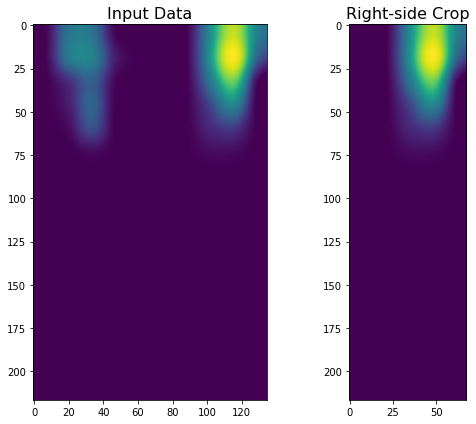

In [227]:
'''
<for testing>
4. Preproceess : fsr matrix image separation (left or right)
   - @brief interpolated high resolution image divide into two class(left, right leg)
   - @method    K Means Clustering
   - @output    class image
'''

import matplotlib.patches as patches
from skimage import io, color
# from scipy.signal import find_peaks
from skimage.feature import peak_local_max
from skimage.feature import blob_dog, blob_log, blob_doh


path = fsr_standard_interpolated_paths[1].loc[:, "path"][1]
raw_image = io.imread(path)
grayscale = color.rgb2gray(raw_image)
crop_right = grayscale[0:grayscale.shape[0],int(grayscale.shape[1]/2):grayscale.shape[1]]
print(crop_right.shape)

fig = plt.figure(figsize=(8,6), constrained_layout=True)

# show input image
fig_raw = fig.add_subplot(1,2,1)
ax_raw = fig_raw.imshow(grayscale)
fig_raw.set_title("Input Data", fontsize=16)

# show cropped image
fig_crop_right = fig.add_subplot(1,2,2)
ax_crop_right = fig_crop_right.imshow(crop_right)
fig_crop_right.set_title("Right-side Crop", fontsize=16)

plt.tight_layout()
plt.show()


#plt.imshow(grayscale)
# fig, ax = plt.subplots()
# ax.imshow(grayscale)
# rect = patches.Rectangle((grayscale.shape[1]/2,0), grayscale.shape[1]/2-1, grayscale.shape[0]-1, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
# ax.add_patch(rect)

# coordinates = peak_local_max(grayscale, min_distance=1)
# plt.scatter(x=coordinates[:,1],y=coordinates[:,0], color='b', s=10)
# plt.show()

# blobs_dog = blob_dog(grayscale, max_sigma=10, threshold=.1)
# blobs_doh = blob_doh(grayscale, max_sigma=10, threshold=.1)
# print(blobs_dog)

# plt.scatter(blobs_dog[:,1], blobs_dog[:,0], color='r', s=10)
# plt.show()


# ax.imshow(cropped)
# plt.show()

In [228]:
'''
xxxxxxxxxxxxxx
4. Preproceess : K Means Clustering for side separation
   - @method    K Means Clustering
   - @output    class image
'''

from sklearn.cluster import KMeans
from skimage import io, color

idx = 1

path = fsr_standard_interpolated_paths[idx].loc[:, "path"][1]
raw_image = io.imread(path)
grayscale = color.rgb2gray(raw_image)
crop_right = grayscale[0:grayscale.shape[0],int(grayscale.shape[1]/2):grayscale.shape[1]]

print(crop_right.shape)

image_dataframe = pd.DataFrame(crop_right)
image_dataframe = image_dataframe.stack().reset_index()
image_dataframe.columns = ['x','y','v']

kmeans = KMeans(n_clusters=2)
kmeans.fit(image_dataframe)

clustered = image_dataframe.copy()
clustered['cluster'] = kmeans.labels_
print(clustered)

# fsr_data = fsr_dataframe[idx].iloc[:,1:161] # extract fsr matrix data
# fsr_data_3d = fsr_data.values.reshape(-1, 16, 10) # reshape the dataframes

# filename = fsr_interpolated_paths[1]["path"][668]
# img = io.imread(filename)
# grayscale = color.rgb2gray(img)
#io.imshow(grayscale)

# img_dataframe = pd.DataFrame(grayscale)
# img_dataframe = img_dataframe.stack().reset_index()
# img_dataframe.columns = ['x','y','v']

'''
kmeans = KMeans(n_clusters=2)
kmeans.fit(img_dataframe)

clustered = img_dataframe.copy()
clustered['cluster'] = kmeans.labels_

print(clustered)
'''

# selection
#cluster_right = clustered[clustered['cluster'] == 1]
#cluster_right = cluster_right.loc[:,['x','y']]
#print(cluster_right)

#plt.figure(figsize=(6,6), constrained_layout=True)
#plt.scatter(cluster_right['x'], cluster_right['y'])
#plt.show()



#print(len(kmeans.labels_))

#result_by_sklearn = grayscale.copy()
#result_by_sklearn["cluster"] = kmeans.labels
#result_by_sklearn.head()


# break

# kmeans = KMeans(n_clusters=2) # k is only 2(left, right)
# kmeans.fit(fsr_data_3d[1])

# # 결과 확인
# result_by_sklearn = points.copy()
# result_by_sklearn["cluster"] = kmeans.labels_
# result_by_sklearn.head()

(217, 68)
         x   y    v  cluster
0        0   0  0.0        1
1        0   1  0.0        1
2        0   2  0.0        1
3        0   3  0.0        1
4        0   4  0.0        1
...    ...  ..  ...      ...
14751  216  63  0.0        0
14752  216  64  0.0        0
14753  216  65  0.0        0
14754  216  66  0.0        0
14755  216  67  0.0        0

[14756 rows x 4 columns]


"\nkmeans = KMeans(n_clusters=2)\nkmeans.fit(img_dataframe)\n\nclustered = img_dataframe.copy()\nclustered['cluster'] = kmeans.labels_\n\nprint(clustered)\n"

In [32]:
'''
6. User Selection
@brief  training phase #1 : user random selection
'''
import random
shuffled_index = np.array(data_config.index)
random.shuffle(shuffled_index)
positive_class = shuffled_index[0:5] # first 5 index select from shuffled_index
negative_class = shuffled_index[5:]
negative_class_zero = np.zeros(len(negative_class), dtype=int)

print(positive_class)
print(negative_class)
print(negative_class_zero)


SIZE = (217, 68) # crop image
CHANNELS = 1 # image channels
NBFRAME = 10 # near frames
BS = 8 #batch size
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,)
print(INSHAPE)

[34  9 28 25  4]
[ 8 19 14 11 17 40 20 10 21  2  5 38 24 43 13  1 22 26  6 30 47 15 45 33
  3 41 32 36 42  7 27 50 48 44 39 12 29 16 37 49 18 31 35 23]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
[34  9 28 25  4  0]
(10, 217, 68, 1)


In [33]:
'''
7. Model Training
@brief  Multiclass Classification using LSTM with keras
'''
import random

# class separation (positive, negative)
shuffled_index = np.array(data_config.index)
random.shuffle(shuffled_index)
positive_class = shuffled_index[0:5] # first 5 index select from shuffled_index
negative_class = shuffled_index[5:]
negative_class_zero = np.zeros(len(negative_class), dtype=int)
classes = np.append(positive_class, 0)


# 1. input image transfer into the convolution network
# - convnet is created and time distributed to detect features
# - the time distributed output is injected to GRU or LSTM to treat "time series"
# - a densenet is the applied to take the decision, to classify
# convnet : for feature extraction, densenet : for decision making

from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
import keras

# user parameters
SIZE = (217, 68) # crop image
CHANNELS = 1 # image channels
NBFRAME = 10 # near frames
BS = 8 #batch size


def build_convnet(shape=(SIZE[0], SIZE[1], CHANNELS)):
    momentum = 0.9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape, padding='same', activation='relu')) # shape = (row, col, channels)
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPool2D())

    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPool2D())

    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPool2D())

    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPool2D())

    # flatten
    model.add(GlobalMaxPool2D())
    return model

from keras.layers import TimeDistributed, GRU, Dense, Dropout

def action_model(shape=(SIZE[0], SIZE[1], CHANNELS), nbout=3):
    #create convnet with (112, 112, 1) input shape
    convnet = build_convnet(shape[1:])

    #then create out final model
    model = keras.Sequential()

    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))

    # you can also use GRU or LSTM
    model.add(GRU(64))

    # finally we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nbout, activation='softmax'))

    return model


# model compile
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

print("done")


done


class 0, validation count: 14, train count: 30
class 1, validation count: 1, train count: 4
class 2, validation count: 1, train count: 4
class 3, validation count: 1, train count: 4
class 4, validation count: 1, train count: 4
class 5, validation count: 1, train count: 4
Total data: 6 classes for 50 files for train
Total data: 6 classes for 19 files for validation


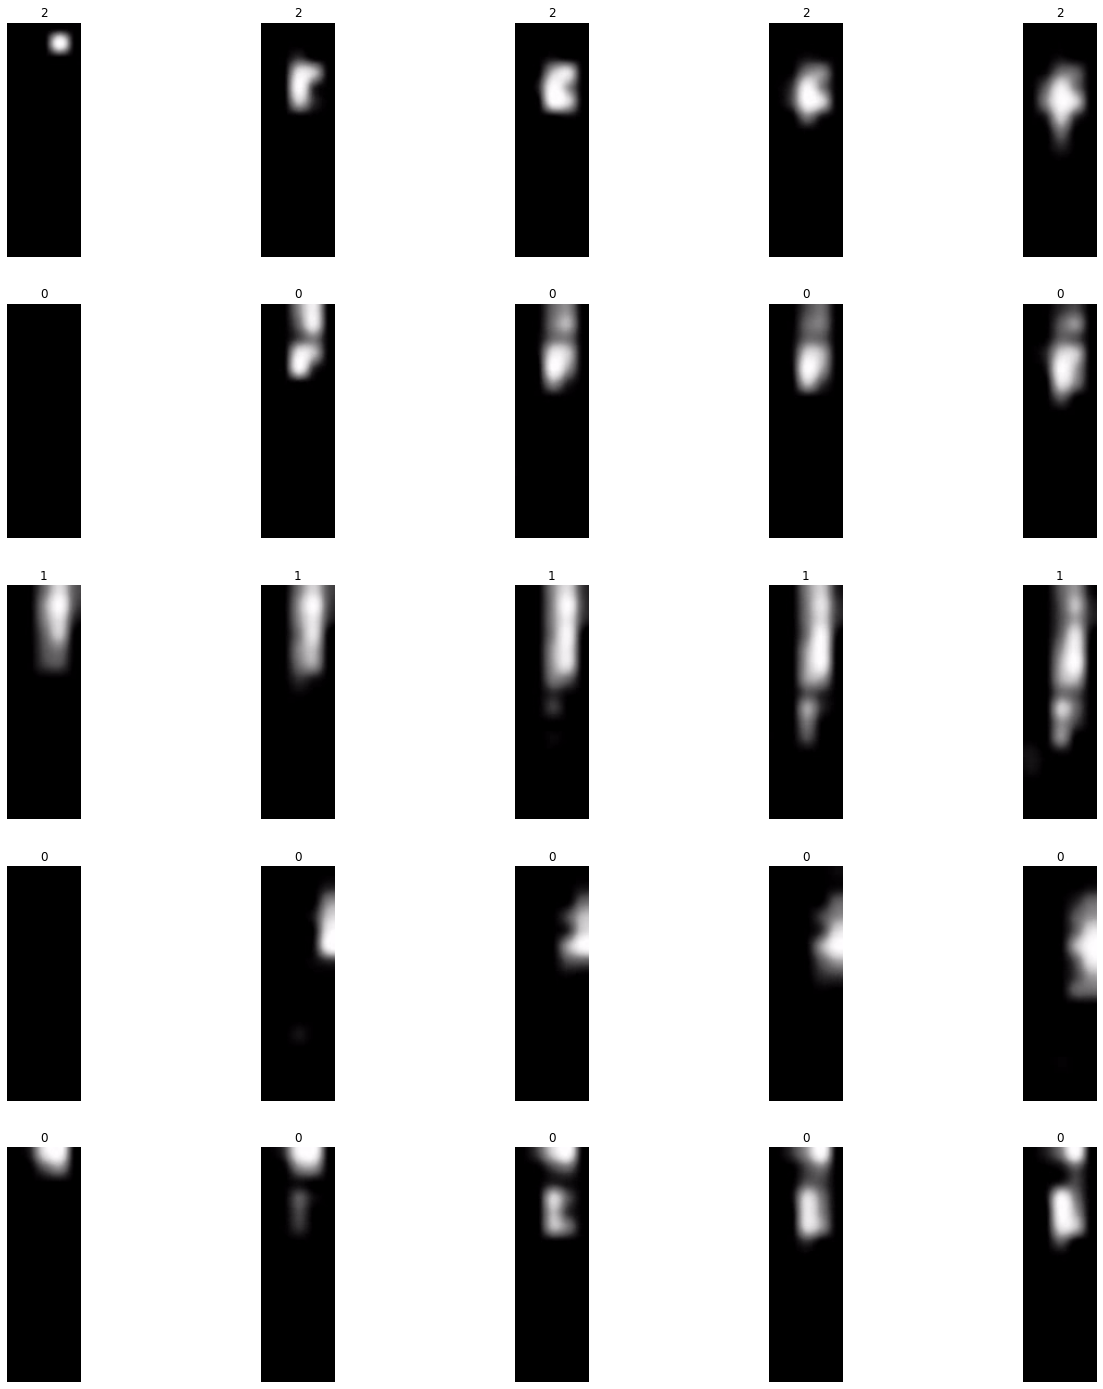

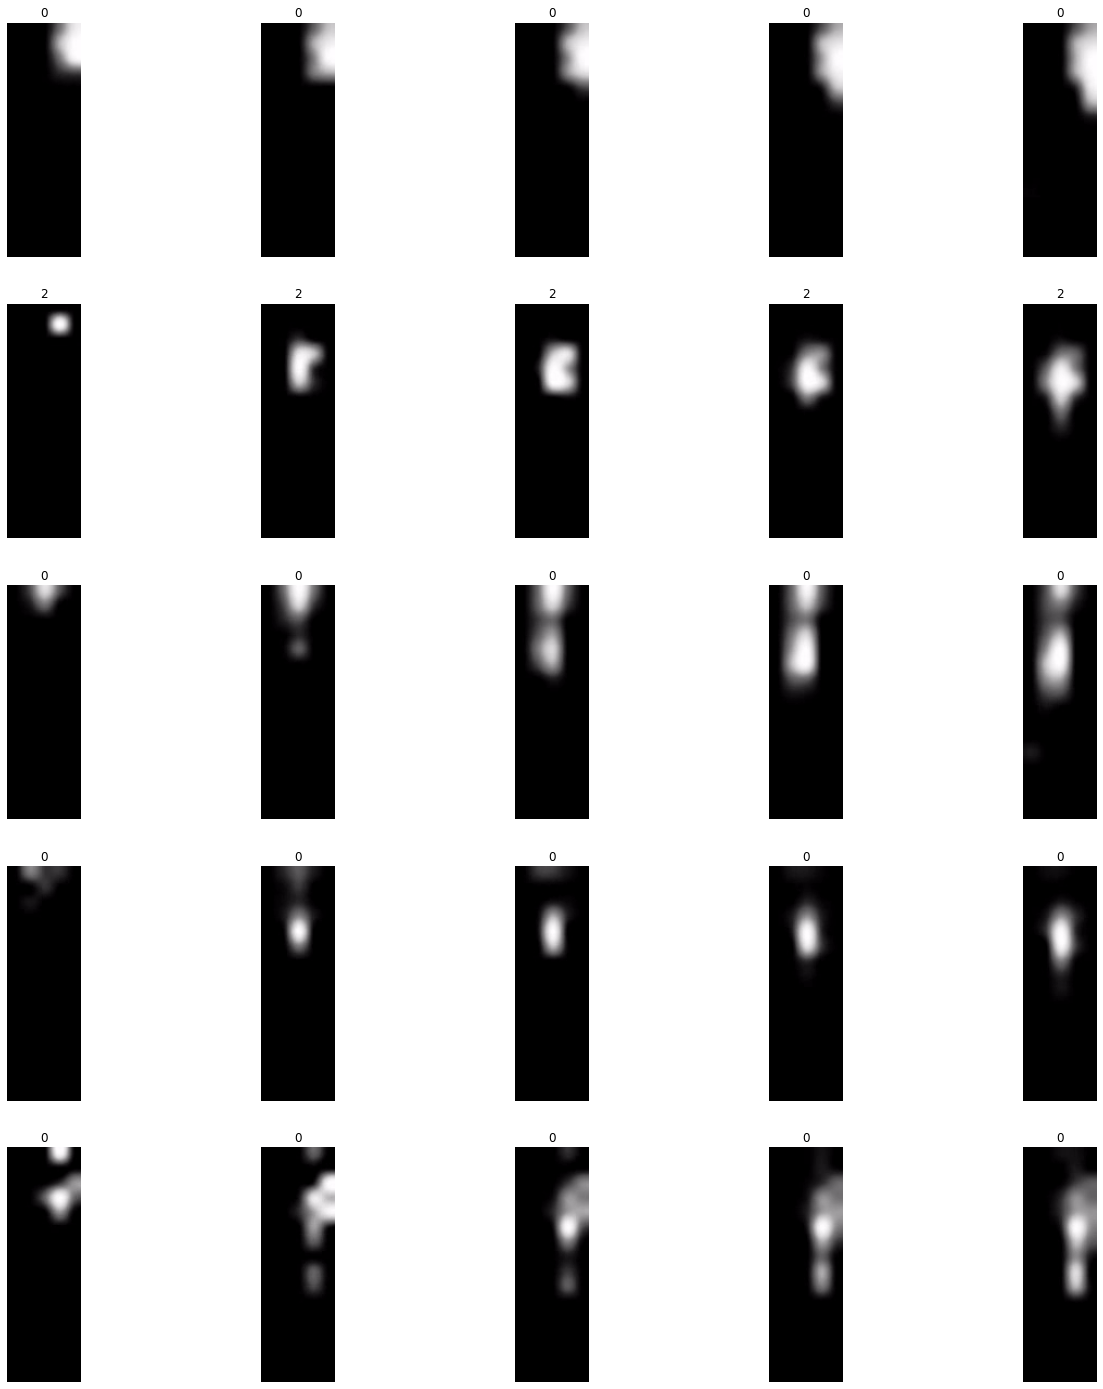

In [55]:
import glob
import os
import keras
from keras_video import VideoFrameGenerator, SlidingFrameGenerator

# use sub directories names as classes
classes = [i.split(os.path.sep)[1] for i in glob.glob('train/*')]
classes.sort()

# some global params
SIZE = (68, 217)
CHANNELS = 3
NBFRAME = 5
BS = 5

# pattern to get videos and classes
glob_pattern='train/{classname}/standard_*.avi'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=False,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.33, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=None,
    use_frame_cache=False)


valid = train.get_validation_generator()


# show selected train sample
from keras_video import utils as ku
ku.show_sample(train, random=True)


In [57]:
EPOCHS=50

# from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale=None)
# train_generator = train_datagen.flow_from_directory(
#         'image/warehouse/handwriting_shape/train',
#         target_size=(24, 24),
#         batch_size=3,
#         class_mode='categorical')

# test_datagen = ImageDataGenerator(rescale=None)
# test_generator = test_datagen.flow_from_directory(
#         'warehouse/handwriting_shape/test',
#         target_size=(24, 24),    
#         batch_size=3,
#         class_mode='categorical')

# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]
model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/50


InvalidArgumentError:  Input to reshape is a tensor with 38400 values, but the requested shape requires a multiple of 5120
	 [[node sequential_1/time_distributed/Reshape_1 (defined at <ipython-input-56-752f3a790a55>:27) ]] [Op:__inference_train_function_5015]

Function call stack:
train_function
